In [ ]:
import os
import random
import sys
import time
import types
from collections import defaultdict, deque
from typing import Any, Callable, Dict, Iterable, List, Literal, Optional, OrderedDict, Tuple, Union

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.attention import SDPBackend, sdpa_kernel

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from tqdm.auto import tqdm
from einops import rearrange
from pytorch3d.ops import sample_farthest_points
from torch_cluster import fps

from linformer import LinformerSelfAttention
from performer_pytorch import SelfAttention as PerformerSelfAttention

In [2]:
class StandardFlashAttention(nn.MultiheadAttention):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout: float = 0.0,
        bias: bool = True,
        add_bias_kv: bool = False,
        add_zero_attn: bool = False,
        kdim: Optional[int] = None,
        vdim: Optional[int] = None,
    ) -> None:
        super().__init__(embed_dim, num_heads, dropout, bias, add_bias_kv, add_zero_attn, kdim, vdim)
        # Note: This implementation assumes that query, key, and value all share the same embedding dimension.

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = True,
        attn_mask: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Implements standard multi-head attention using F.scaled_dot_product_attention.
        Expects inputs of shape (batch, seq_length, embed_dim).
        Returns:
          - attn_output: (batch, seq_length, embed_dim)
          - avg_attn_weights: (batch, seq_length, seq_length) if need_weights is True, else None.
        """
        # Get batch size, sequence length and embedding dimension.
        B, L, E = query.shape
        assert E == self.embed_dim, f"Expected embed_dim {self.embed_dim} but got {E}"
        head_dim = self.embed_dim // self.num_heads
        scaling = head_dim ** -0.5

        # Compute Q, K, V using the in_proj parameters.
        # When kdim and vdim are None, self.in_proj_weight and self.in_proj_bias contain
        # the concatenated weights for Q, K, and V.
        qkv = F.linear(query, self.in_proj_weight, self.in_proj_bias)  # shape: (B, L, 3*embed_dim)
        q, k, v = qkv.chunk(3, dim=-1)  # each has shape: (B, L, embed_dim)

        # Reshape Q, K, V for multi-head attention.
        # New shape: (B, num_heads, L, head_dim)
        q = q.reshape(B, L, self.num_heads, head_dim).transpose(1, 2)
        k = k.reshape(B, L, self.num_heads, head_dim).transpose(1, 2)
        v = v.reshape(B, L, self.num_heads, head_dim).transpose(1, 2)

        # Scale the queries.
        q = q * scaling

        # Use F.scaled_dot_product_attention for the attention calculation.
        with sdpa_kernel(backends=[SDPBackend.FLASH_ATTENTION]):
            attn_output = F.scaled_dot_product_attention(
                q, k, v, attn_mask=attn_mask, dropout_p=self.dropout, is_causal=False
            )

        # Recombine heads and reshape to (B, L, embed_dim).
        attn_output = attn_output.transpose(1, 2).reshape(B, L, self.embed_dim)

        # Apply the final linear projection.
        attn_output = F.linear(attn_output, self.out_proj.weight, self.out_proj.bias)

        return attn_output,

In [ ]:
class FastNystromAttention(nn.MultiheadAttention):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout: float = 0.0,
        bias: bool = True,
        add_bias_kv: bool = False,
        add_zero_attn: bool = False,
        kdim: Optional[int] = None,
        vdim: Optional[int] = None,
        num_sample: int = 128,
        resample_fps: bool = False,
    ) -> None:
        super().__init__(embed_dim, num_heads, dropout, bias, add_bias_kv, add_zero_attn, kdim, vdim)
        self.num_sample = num_sample
        self.resample_fps = resample_fps
        self._cache: Dict[str, Any] = {}

    def load_cache(self, d: Dict[str, torch.Tensor]) -> None:
        self._cache.clear()
        self._cache.update(d)
    
    def update_cache(self, d: Dict[str, torch.Tensor]) -> None:
        self._cache.update(d)

    @classmethod
    def invert(cls, A: torch.Tensor) -> torch.Tensor:
        # This is the exact coefficient computation, 1 / ||K||_1, of initialization of Z_0, leading to faster convergence.
        dtype = A.dtype
        I = torch.eye(A.shape[-1], device=A.device, dtype=dtype)
        Z = 1 / torch.max(torch.sum(A, dim=-2, keepdim=True), dim=-1, keepdim=True).values * A.mT
        for _ in range(4):
            AZ = A @ Z
            Z = 0.25 * Z @ (13 * I - AZ @ (15 * I - AZ @ (7 * I - AZ)))
        return Z

    def forward(
        self, 
        query: torch.Tensor,
        key: torch.Tensor, 
        value: torch.Tensor,
        key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = True,
        attn_mask: Optional[torch.Tensor] = None,
        average_attn_weights: bool = True,
        is_causal: bool = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        assert key is query and value is query, "Only implemented for k_x and v_x as None"
        mask_dict: Dict[str, torch.Tensor] = self._cache.get("mask_dict", {})
        device=query.device
        
        ln1_x = query
        qkv = F.linear(query, self.in_proj_weight, self.in_proj_bias)
        query, key, value = rearrange(qkv, "b n (qkv h d) -> qkv b h n d", qkv=3, h=self.num_heads)
        
        bsz = query.shape[0]
        bsz_index = torch.arange(bsz, device=device)[:, None]
        head_dim = query.shape[-1]
        invsqrt_d = head_dim ** -0.5
        
        def index(t: torch.Tensor, sample_indices: torch.Tensor) -> torch.Tensor:
            return rearrange(t[bsz_index, :, sample_indices, :], "bsz s h d -> bsz h s d")
            
        # SECTION: Construct the queries and keys used to extrapolate the attention matrix            
        sample_indices = self._cache.get("fps_indices", None)
        if self.resample_fps or sample_indices is None:
            guarantee_mask = mask_dict["guarantee"]                                 # bool: [bsz x N]
            exclude_mask = mask_dict["exclude"]                                     # bool: [bsz x N]
            
            restricted_samples = self.num_sample - torch.sum(guarantee_mask, dim=1) # int: [bsz]
            max_restricted_samples: int = torch.max(restricted_samples).item()      # int       
            
            restricted_mask = ~guarantee_mask * ~exclude_mask                       # bool: [bsz x N]
            counts = torch.sum(restricted_mask, dim=1)                              # [bsz]
            max_count: int = torch.max(counts).item()                               # int

            topk_indices = torch.topk(restricted_mask.to(torch.int), k=max_count, dim=1).indices    # int: [bsz x max_count]
            fps_indices = sample_farthest_points(
                ln1_x[bsz_index, topk_indices],
                lengths=counts, K=restricted_samples,
            )[1]                                                                                # int: [bsz x max_restricted_samples]

            sample_indices = torch.cat((
                topk_indices, torch.full((bsz, 1), -1, device=device)
            ), dim=1)[bsz_index, fps_indices]                                                   # int: [bsz x max_restricted_samples]
            if self.num_sample > max_restricted_samples:
                sample_indices = torch.cat((
                    sample_indices, torch.full((bsz, self.num_sample - max_restricted_samples), -1, device=device)
                ), dim=1)
            sample_indices[sample_indices == -1] = torch.where(guarantee_mask)[1]
            
            self.update_cache({"fps_indices": sample_indices})

        qp, kp = index(query, sample_indices), index(key, sample_indices)                       # float: [bsz x h x num_sample x d]  
        with sdpa_kernel(backends=[SDPBackend.FLASH_ATTENTION]): 
            Bv = F.scaled_dot_product_attention(qp, key, value)                                 # float: [bsz x h x num_sample x N]
        BT = torch.softmax(query @ (invsqrt_d * kp.mT), dim=-1)                                 # float: [bsz x h x N x num_sample]
        A = rearrange(BT[bsz_index, :, sample_indices, :], "bsz s1 h s2 -> bsz h s1 s2")        # float: [bsz x h x num_sample x num_sample]
        x = (BT @ self.invert(A)) @ Bv                                                          # float: [bsz x h x N x d]
        #x = BT @ Bv

        x = rearrange(x, "b h n d -> b n (h d)")    
        x = F.linear(x, self.out_proj.weight, self.out_proj.bias)
        return x,

In [8]:
class LinformerAttention(nn.MultiheadAttention):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout: float = 0.0,
        bias: bool = True,
        add_bias_kv: bool = False,
        add_zero_attn: bool = False,
        kdim: Optional[int] = None,
        vdim: Optional[int] = None,
        k: int = 256,  # projection dimension for Linformer
        seq_len: int = 16384  # max sequence length for Linformer
    ) -> None:
        super().__init__(embed_dim, num_heads, dropout, bias, add_bias_kv, add_zero_attn, kdim, vdim)
        self.k = k
        self.seq_len = seq_len
        self.linformer_attn = LinformerSelfAttention(
            dim=embed_dim,
            seq_len=seq_len,
            k=k,
            heads=num_heads,
            dim_head=embed_dim // num_heads,
            dropout=dropout
        )

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = True,
        attn_mask: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        return self.linformer_attn(query), None

In [9]:
class PerformerAttention(nn.MultiheadAttention):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout: float = 0.0,
        bias: bool = True,
        add_bias_kv: bool = False,
        add_zero_attn: bool = False,
        kdim: Optional[int] = None,
        vdim: Optional[int] = None,
        nb_features: int = None,  # number of random features for Performer
    ) -> None:
        super().__init__(embed_dim, num_heads, dropout, bias, add_bias_kv, add_zero_attn, kdim, vdim)
        self.performer_attn = PerformerSelfAttention(
            dim=embed_dim,
            heads=num_heads,
            dim_head=embed_dim // num_heads,
            nb_features=nb_features,  # defaults to dim_head * log(dim_head) internally
            causal=False,
            dropout=dropout
        )

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = True,
        attn_mask: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        return self.performer_attn(query), None

In [10]:
# Initialize the attention modules.
embed_dim = 1024
num_heads = 16
device = 'cuda:1'
torch.cuda.set_device(device)

# Select the dtype for testing
dtype = torch.float16  # Change this to torch.float16, torch.bfloat16, etc.
print(f"Testing with dtype: {dtype}")

# Built-in attention (using batch_first=True)
sanity_check_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
sanity_check_attn.eval()
sanity_check_attn.requires_grad_(False)
sanity_check_attn = sanity_check_attn.to(dtype)

standard_flash_attn = StandardFlashAttention(embed_dim=embed_dim, num_heads=num_heads)
standard_flash_attn.load_state_dict(sanity_check_attn.state_dict())
standard_flash_attn.eval()
standard_flash_attn.requires_grad_(False)
standard_flash_attn = standard_flash_attn.to(dtype)

fast_nystrom_attn = FastNystromAttention(embed_dim=embed_dim, num_heads=num_heads, num_sample=32, resample_fps=False)
fast_nystrom_attn.load_state_dict(sanity_check_attn.state_dict())
fast_nystrom_attn.eval()
fast_nystrom_attn.requires_grad_(False)
fast_nystrom_attn = fast_nystrom_attn.to(dtype)

linformer_attn = LinformerAttention(embed_dim=embed_dim, num_heads=num_heads, k=32)
linformer_attn.eval()
linformer_attn.requires_grad_(False)
linformer_attn = linformer_attn.to(dtype)

performer_attn = PerformerAttention(embed_dim=embed_dim, num_heads=num_heads, nb_features=32)
performer_attn.eval()
performer_attn.requires_grad_(False)
performer_attn = performer_attn.to(dtype)

print("Loaded attention layers")

# Move modules to GPU.
sanity_check_attn = sanity_check_attn.to(device)
standard_flash_attn = standard_flash_attn.to(device)
fast_nystrom_attn = fast_nystrom_attn.to(device)
linformer_attn = linformer_attn.to(device)
performer_attn = performer_attn.to(device)

batch_size = 4
hidden_dim = embed_dim

# Define the sequence lengths to test.
seq_lens = [256, 512, 1024, 2048, 4096, 8192, 16384] 
iterations = 100

# Lists for timing and memory usage (peak in bytes).
times_sanity = []
times_standard_flash = []
times_fast_nystrom_no_resample = []
times_linformer = []
times_performer = []
mem_usage_sanity = []
mem_usage_standard_flash = []
mem_usage_fast_nystrom_no_resample = []
mem_usage_linformer = []
mem_usage_performer = []

for seq_len in seq_lens:
    print(f"Testing sequence length: {seq_len}")
    test_batch = torch.randn(batch_size, seq_len, hidden_dim, dtype=dtype).to(device)
    mask_dict = {
        'guarantee': torch.zeros(batch_size, seq_len, dtype=torch.bool, device=device),
        'exclude': torch.zeros(batch_size, seq_len, dtype=torch.bool, device=device)
    }
    
    # Warm-up runs
    with torch.no_grad():
        for _ in range(10):
            _ = sanity_check_attn(test_batch, test_batch, test_batch)
            _ = standard_flash_attn(test_batch, test_batch, test_batch)
            fast_nystrom_attn.load_cache({'mask_dict': mask_dict})
            fast_nystrom_attn.resample_fps = False
            _ = fast_nystrom_attn(test_batch, test_batch, test_batch)
            _ = linformer_attn(test_batch, test_batch, test_batch)
            _ = performer_attn(test_batch, test_batch, test_batch)
    
    # Built-in attention timing and memory measurement
    # torch.cuda.synchronize()
    # torch.cuda.reset_peak_memory_stats(device)
    # start_time = time.time()
    # with torch.no_grad():
    #     for _ in range(iterations):
    #         _ = sanity_check_attn(test_batch, test_batch, test_batch)
    # torch.cuda.synchronize()
    # t = time.time() - start_time
    # times_sanity.append(t / iterations)
    # mem_usage_sanity.append(torch.cuda.max_memory_allocated(device))

    # Standard Flash Attention timing and memory measurement
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats(device)
    start_time = time.time()
    with torch.no_grad():
        for _ in range(iterations):
            _ = standard_flash_attn(test_batch, test_batch, test_batch)
    torch.cuda.synchronize()
    t = time.time() - start_time
    times_standard_flash.append(t / iterations)
    mem_usage_standard_flash.append(torch.cuda.max_memory_allocated(device))
    
    # Fast Nystrom Attention: NO RESAMPLE mode timing and memory measurement
    torch.cuda.synchronize()
    fast_nystrom_attn.load_cache({'mask_dict': mask_dict})
    fast_nystrom_attn.resample_fps = False
    torch.cuda.reset_peak_memory_stats(device)
    start_time = time.time()
    with torch.no_grad():
        for _ in range(iterations):
            _ = fast_nystrom_attn(test_batch, test_batch, test_batch)
    torch.cuda.synchronize()
    t = time.time() - start_time
    times_fast_nystrom_no_resample.append(t / iterations)
    mem_usage_fast_nystrom_no_resample.append(torch.cuda.max_memory_allocated(device))

    # Linformer timing and memory measurement
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats(device)
    start_time = time.time()
    with torch.no_grad():
        for _ in range(iterations):
            _ = linformer_attn(test_batch, test_batch, test_batch)
    torch.cuda.synchronize()
    t = time.time() - start_time
    times_linformer.append(t / iterations)
    mem_usage_linformer.append(torch.cuda.max_memory_allocated(device))

    # Performer timing and memory measurement
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats(device)
    start_time = time.time()
    with torch.no_grad():
        for _ in range(iterations):
            _ = performer_attn(test_batch, test_batch, test_batch)
    torch.cuda.synchronize()
    t = time.time() - start_time
    times_performer.append(t / iterations)
    mem_usage_performer.append(torch.cuda.max_memory_allocated(device))

# Conversion factors: 1 second = 1000 ms, 1 MB = 1048576 bytes.
#times_sanity_ms = [t * 1000 for t in times_sanity]
times_standard_flash_ms = [t * 1000 for t in times_standard_flash]
times_fast_nystrom_no_resample_ms = [t * 1000 for t in times_fast_nystrom_no_resample]
times_linformer_ms = [t * 1000 for t in times_linformer]
times_performer_ms = [t * 1000 for t in times_performer]

#mem_usage_sanity_mb = [mem / 1048576 for mem in mem_usage_sanity]
mem_usage_standard_flash_mb = [mem / 1048576 for mem in mem_usage_standard_flash]
mem_usage_fast_nystrom_no_resample_mb = [mem / 1048576 for mem in mem_usage_fast_nystrom_no_resample]
mem_usage_linformer_mb = [mem / 1048576 for mem in mem_usage_linformer]
mem_usage_performer_mb = [mem / 1048576 for mem in mem_usage_performer]

print("Timing results (ms):")
print("Sequence lengths:", seq_lens)
#print("Built-in attention:", times_sanity_ms)
print("Standard Flash Attention:", times_standard_flash_ms)
print("Fast Nystrom (no resample):", times_fast_nystrom_no_resample_ms)
print("Linformer:", times_linformer_ms)
print("Performer:", times_performer_ms)

print("\nPeak GPU Memory Usage (MB):")
#print("Built-in attention:", mem_usage_sanity_mb)
print("Standard Flash Attention:", mem_usage_standard_flash_mb)
print("Fast Nystrom (no resample):", mem_usage_fast_nystrom_no_resample_mb)
print("Linformer:", mem_usage_linformer_mb)
print("Performer:", mem_usage_performer_mb)

Testing with dtype: torch.float16
Loaded attention layers
Testing sequence length: 256


IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [256, 1], [4, 256]

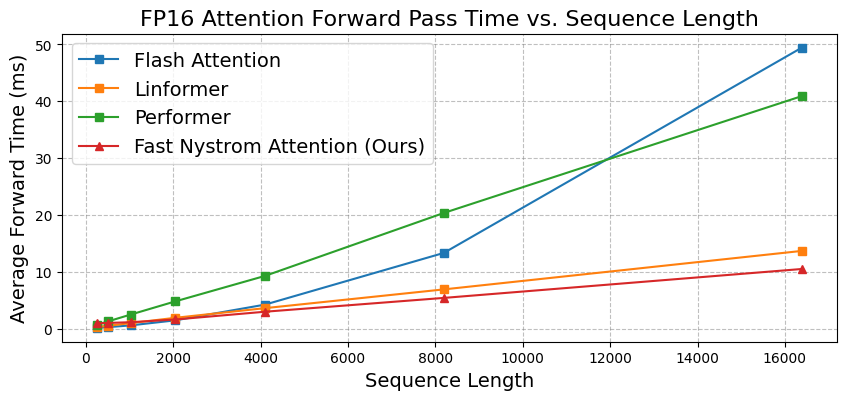

In [ ]:
plt.figure(figsize=(10, 4))
#plt.plot(seq_lens, [t * 1000 for t in times_sanity], marker='o', label="nn.MultiheadAttention")
plt.plot(seq_lens, [t * 1000 for t in times_standard_flash], marker='s', label="Flash Attention")
plt.plot(seq_lens, [t * 1000 for t in times_linformer], marker='s', label="Linformer")
plt.plot(seq_lens, [t * 1000 for t in times_performer], marker='s', label="Performer")
plt.plot(seq_lens, [t * 1000 for t in times_fast_nystrom_no_resample], marker='^', label="Fast Nystrom Attention (Ours)")
plt.xlabel("Sequence Length", fontsize=14)
plt.ylabel("Average Forward Time (ms)", fontsize=14)
plt.title("FP16 Attention Forward Pass Time vs. Sequence Length", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', color='gray', alpha=0.5)
#plt.savefig('fp16_attention_timing_plot.pdf', bbox_inches='tight')
plt.show()
plt.close()

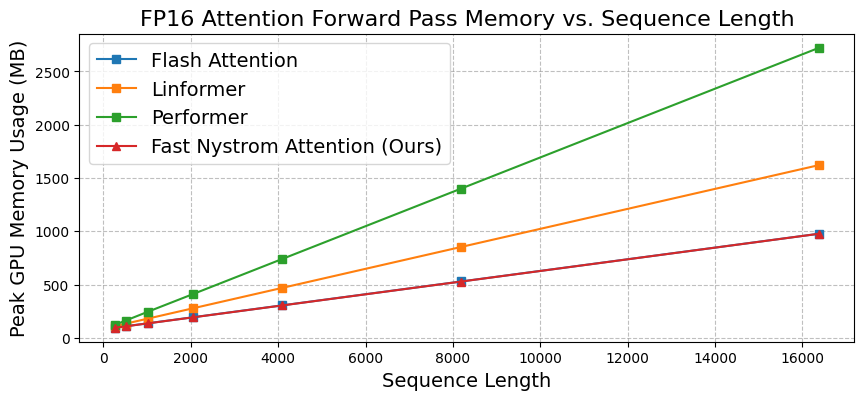

In [ ]:
# Plotting memory usage
plt.figure(figsize=(10, 4))
#plt.plot(seq_lens, mem_usage_sanity_mb, marker='o', label="nn.MultiheadAttention")
plt.plot(seq_lens, mem_usage_standard_flash_mb, marker='s', label="Flash Attention")
plt.plot(seq_lens, mem_usage_linformer_mb, marker='s', label="Linformer")
plt.plot(seq_lens, mem_usage_performer_mb, marker='s', label="Performer")
plt.plot(seq_lens, mem_usage_fast_nystrom_no_resample_mb, marker='^', label="Fast Nystrom Attention (Ours)")
plt.xlabel("Sequence Length", fontsize=14)
plt.ylabel("Peak GPU Memory Usage (MB)", fontsize=14)
plt.title("FP16 Attention Forward Pass Memory vs. Sequence Length", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', color='gray', alpha=0.5)
#plt.savefig('fp16_attention_memory_plot.pdf', bbox_inches='tight')
plt.show()
plt.close()